# Deep Learning Final Project: Detecting COVID-19 with Chest X-Ray using PyTorch

## Project Description
**The research problem and objective** of this project is, whether we can identify COVID-19 positive cases, Lung Opacity cases, Viral Pneumonia cases or Normal cases using deep learning image classification model on Chest X-Ray (CXR) scans with a reasonably high accuracy.

**The dataset: "COVID-19 Radiography Database"** taken from Kaggle - https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database

In the 2nd update of this dataset, we have 21,165 total cases, which are categorized in four classes:
 - 3616 COVID-19 positive cases
 - 10,192 Normal cases
 - 6012 Lung Opacity (Non-COVID lung infection) cases
 - 1345 Viral Pneumonia cases

In addition, there are corresponding lung masks.
(This dataset will continue to be updated as soon as they have new x-ray images for COVID-19 pneumonia patients).

**Note:** This dataset, and the model that we train in the project, can not be used to diagnose COVID-19 or Viral Pneumonia. We are only using this data for **educational purpose.**
Researchers can use this database to produce useful and impactful scholarly work on COVID-19, which can help in tackling this pandemic.

**Image Formats:**
All the images are in Portable Network Graphics (PNG) file format and the resolution are 256*256 pixels.

**Architecture:** We will use **ResNet-18 model** and compare it to **ResNet-50** and **VGG19**. The ResNet-18 model is a Convolutional Neural Network (CNN) with 18 layers, and has been pre-trained on a large dataset (such as **ImageNet**) with *millions of images*, allowing it to learn general representations of various visual concepts. By leveraging **transfer learning**, this project takes advantage of the ResNet-18 model's pre-trained weights and fine-tunes it specifically for the problem at hand.

One of the key benefits of this model is **Computational Efficiency:** ResNet-18 strikes a good balance between model complexity and computational efficiency. It offers a relatively compact architecture compared to deeper models like **ResNet-50**, making it easier to train and deploy, especially for projects with limited computational resources.

## Citations

Article (1): "Can AI Help in Screening Viral and COVID-19 Pneumonia?" - https://ieeexplore.ieee.org/document/9144185

Article (2): "Exploring the effect of image enhancement techniques on COVID-19 detection using chest X-ray images" - https://www.sciencedirect.com/science/article/pii/S001048252100113X?via%3Dihub

# Preliminaries

## Import Statements

In [ ]:
%matplotlib inline

import os
import shutil
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F # for softmax
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import torchvision
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, ToTensor, Normalize # Image Transformations
from torchvision.models import resnet18, resnet50, vgg19, densenet121, ResNet18_Weights, ResNet50_Weights, VGG19_Weights, DenseNet121_Weights

from PIL import Image

from datetime import datetime
import pytz # timezone

from tqdm import trange # used to make our loops show a smart progress meter

torch.manual_seed(42)

print("Using PyTorch version", torch.__version__)
print("Using torchvision version", torchvision.__version__)
print("Using pandas version", pd.__version__)

Using PyTorch version 2.0.1+cu118
Using torchvision version 0.15.2+cu118
Using pandas version 1.5.3


## Set torch GPU device

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu") # (TODO: change "cpu" to "device error"?)
device

There are 1 GPU(s) available.
We will use the GPU: NVIDIA A100-SXM4-40GB


device(type='cuda')

## Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## List directory

In [ ]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'HIT/Deep Learning/Final Project/data'
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

/content/drive/My Drive/HIT/Deep Learning/Final Project/data
['COVID.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'README.md.txt', 'COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia', 'test', '.ipynb_checkpoints', 'resnet18_model', 'resnet50_model']


In [ ]:
os.chdir(GOOGLE_DRIVE_PATH)

# Read Data

In [ ]:
df_covid = pd.read_excel('COVID.metadata.xlsx')
print(df_covid.shape)
df_covid

(3616, 4)


FILE NAME FORMAT     SIZE  \
0        COVID-1    PNG  256*256   
1        COVID-2    PNG  256*256   
2        COVID-3    PNG  256*256   
3        COVID-4    PNG  256*256   
4        COVID-5    PNG  256*256   
...          ...    ...      ...   
3611  COVID-3612    PNG  256*256   
3612  COVID-3613    PNG  256*256   
3613  COVID-3614    PNG  256*256   
3614  COVID-3615    PNG  256*256   
3615  COVID-3616    PNG  256*256   

                                                    URL  
0     https://sirm.org/category/senza-categoria/covi...  
1     https://sirm.org/category/senza-categoria/covi...  
2     https://sirm.org/category/senza-categoria/covi...  
3     https://sirm.org/category/senza-categoria/covi...  
4     https://sirm.org/category/senza-categoria/covi...  
...                                                 ...  
3611  https://bimcv.cipf.es/bimcv-projects/bimcv-cov...  
3612  https://bimcv.cipf.es/bimcv-projects/bimcv-cov...  
3613  https://bimcv.cipf.es/bimcv-projects/bimcv-cov...  
3614  https://bimcv.cipf.es/bimcv-projects/bimcv-cov...  
3615  https://bimcv.cipf.es/bimcv-projects/bimcv-cov...  

[3616 rows x 4 columns]

In [ ]:
df_normal = pd.read_excel('Normal.metadata.xlsx')
print(df_normal.shape)
df_normal

In [ ]:
df_lung_opacity = pd.read_excel('Lung_Opacity.metadata.xlsx')
print(df_lung_opacity.shape)
df_lung_opacity

In [ ]:
df_viral = pd.read_excel('Viral Pneumonia.metadata.xlsx')
print(df_viral.shape)
df_viral

In [ ]:
class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

## Maintenance functions (Prepare Test folders, move 20% of files from train to test folders)

In [ ]:
# create test folders if they don't exist
# if not os.path.isdir(os.path.join(GOOGLE_DRIVE_PATH, 'test')):
#   print("Creating test folders...")
#   os.mkdir(os.path.join(GOOGLE_DRIVE_PATH, 'test'))

#   for c in class_names:
#     os.mkdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', c))
#     os.mkdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'images'))
#     os.mkdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'masks'))

In [ ]:
# %%time
# def count_files_short():
#   print("Counting COVID files...")
#   train_images = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, 'COVID', 'images'))
#   test_images = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', 'COVID', 'images'))
#   print(f'train set: images: {len(train_images)}')
#   print(f'test set: images: {len(test_images)}')
#   print(f'total: images: {len(train_images) + len(test_images)}')
# #count_files_short()

In [ ]:
# %%time
# def count_all_files():
#   print("Counting all files...")
#   for c in class_names:
#     train_images = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, c, 'images'))
#     train_masks = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, c, 'masks'))
#     test_images = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'images'))
#     test_masks = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'masks'))
#     print(f'{c}:')
#     print(f'train set: images: {len(train_images)}')
#     print(f'train set: masks: {len(train_masks)}')
#     print(f'test set: images: {len(test_images)}')
#     print(f'test set: masks: {len(test_masks)}')
#     print(f'total images: {len(train_images)+len(test_images)}')
#     print(f'total masks: {len(train_masks)+len(test_masks)}')
#     print("-"*20)
# #count_all_files()

In [ ]:
# %%time
# test_size = 0.2

# # move files from train to test
# print("Moving files from train to test...")
# for c in class_names:
#   images = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, c, 'images'))
#   masks = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, c, 'masks'))

#   print(f'Currently in train set - {c} images: {len(images)}')
#   print(f'Currently in train set - {c} masks: {len(masks)}')

#   #selected_images = random.sample(images, 30)
#   #selected_masks = random.sample(masks, 30)

#   selected_images = random.sample(images, int(test_size*len(images)))
#   selected_masks = random.sample(masks, int(test_size*len(masks)))

#   print(f'Moving {len(selected_images)} {c} images to test folders')
#   for image in selected_images:
#     source_path = os.path.join(GOOGLE_DRIVE_PATH, c, 'images', image)
#     target_path = os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'images', image)
#     shutil.move(source_path, target_path)

#   print(f'Moving {len(selected_masks)} {c} masks to test folders')
#   for mask in selected_masks:
#     source_path = os.path.join(GOOGLE_DRIVE_PATH, c, 'masks', mask)
#     target_path = os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'masks', mask)
#     shutil.move(source_path, target_path)

Move files back from test folders to corresponding train folders

In [ ]:
# %%time
# def move_all_test_files_back_to_train():
#   print("Moving files back from test to train folders...")
#   for c in class_names:
#     test_images = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'images'))
#     print(f'Num of {c} test images:{len(test_images)}')
#     for image in test_images:
#       source_path = os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'images', image)
#       target_path = os.path.join(GOOGLE_DRIVE_PATH, c, 'images', image)
#       shutil.move(source_path, target_path)

#     test_masks = os.listdir(os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'masks'))
#     print(f'Num of {c} test masks:{len(test_masks)}')
#     for mask in test_masks:
#       source_path = os.path.join(GOOGLE_DRIVE_PATH, 'test', c, 'masks', mask)
#       target_path = os.path.join(GOOGLE_DRIVE_PATH, c, 'masks', mask)
#       shutil.move(source_path, target_path)

# #move_all_test_files_back_to_train()

# Define CXRDataset class

In [ ]:
class CXRDataset(Dataset):
    def __init__(self, image_dirs, transform):
        self.image_dirs = image_dirs
        self.transform = transform

        self.images = {}
        self.class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

        def get_images(class_name):
            images = os.listdir(image_dirs[class_name])
            print(f'Found {len(images)} {class_name} cases')
            return images

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)

    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])

# Image Transformations

In [ ]:
train_transform = Compose([Resize(size=(224, 224)), RandomHorizontalFlip(), ToTensor(),
                           Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = Compose([Resize(size=(224, 224)), ToTensor(),
                          Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Prepare DataLoaders

In [ ]:
%%time
train_dirs = {
    'COVID': os.path.join(GOOGLE_DRIVE_PATH, 'COVID', 'images'),
    'Normal': os.path.join(GOOGLE_DRIVE_PATH, 'Normal', 'images'),
    'Lung_Opacity': os.path.join(GOOGLE_DRIVE_PATH, 'Lung_Opacity', 'images'),
    'Viral Pneumonia': os.path.join(GOOGLE_DRIVE_PATH, 'Viral Pneumonia', 'images')
}

train_dataset = CXRDataset(image_dirs=train_dirs, transform=train_transform)

Found 2893 COVID cases
Found 8154 Normal cases
Found 4810 Lung_Opacity cases
Found 1076 Viral Pneumonia cases
CPU times: user 442 ms, sys: 69.2 ms, total: 511 ms
Wall time: 1min 59s


In [ ]:
%%time
test_dirs = {
    'COVID': os.path.join(GOOGLE_DRIVE_PATH, 'test', 'COVID', 'images'),
    'Normal': os.path.join(GOOGLE_DRIVE_PATH, 'test', 'Normal', 'images'),
    'Lung_Opacity': os.path.join(GOOGLE_DRIVE_PATH, 'test', 'Lung_Opacity', 'images'),
    'Viral Pneumonia': os.path.join(GOOGLE_DRIVE_PATH, 'test', 'Viral Pneumonia', 'images')
}

test_dataset = CXRDataset(image_dirs=test_dirs, transform=test_transform)

Found 723 COVID cases
Found 2038 Normal cases
Found 1202 Lung_Opacity cases
Found 269 Viral Pneumonia cases
CPU times: user 99.5 ms, sys: 24.8 ms, total: 124 ms
Wall time: 27.9 s


In [ ]:
BATCH_SIZE = 6

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) # (TODO: shuffle=False?)

print('Number of training batches', len(train_loader))
print('Number of test batches', len(test_loader))

Number of training batches 2823
Number of test batches 706


# Data Visualization - show_images() function

In [ ]:
def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, BATCH_SIZE, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

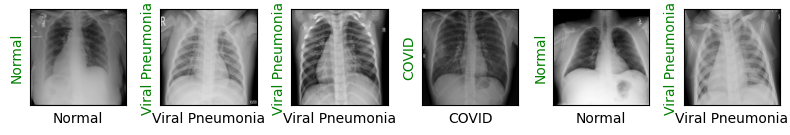

In [ ]:
# show train images
images, labels = next(iter(train_loader))
show_images(images, labels, labels)

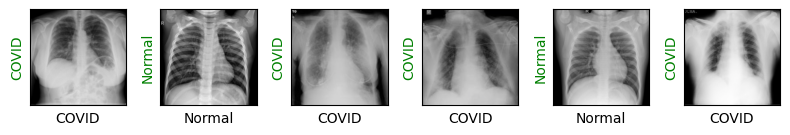

In [ ]:
# show test images
images, labels = next(iter(test_loader))
show_images(images, labels, labels)

# Models

## Some interesting links
https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

## Training Hyperparameters

In [ ]:
NUM_EPOCHS = 1
LEARNING_RATE = 3e-5

## Set loss function

In [ ]:
loss_fn = nn.CrossEntropyLoss()

## print_results() function

In [ ]:
def print_results(y_true, y_pred):
  average_type = 'weighted' # or 'macro'

  #accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average=average_type)
  recall = recall_score(y_true, y_pred, average=average_type)
  f1 = f1_score(y_true, y_pred, average=average_type)

  #print(f'Accuracy: {accuracy:.4f}')
  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1-score: {f1:.4f}')

  # Classification Report
  report = classification_report(y_true, y_pred, target_names=class_names)
  print(f"\nClassification Report:\n{report}")

  # Confusion Matrix
  cm = confusion_matrix(y_true, y_pred)
  print('Confusion Matrix:')
  print(cm)

## ResNet-18

### Create the Model

In [ ]:
resnet18_model = resnet18(weights=ResNet18_Weights.DEFAULT)

print(resnet18_model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Set final layer and optimizer

In [ ]:
resnet18_model.fc = nn.Linear(in_features=512, out_features=4)
resnet18_optimizer = Adam(resnet18_model.parameters(), lr=LEARNING_RATE)

### show_preds() function

In [ ]:
def show_preds(model):
    # Put the model into evaluation mode which disables dropout and batch normalization layers
    model.eval()
    '''
    After the training loop, you can call model.eval() to switch the model to evaluation mode.
    In evaluation mode, the behavior of dropout and batch normalization layers changes.
    Dropout layers no longer drop inputs, and batch normalization layers use the running statistics computed during training instead of calculating batch-wise statistics.
    It's essential to set the model to the appropriate mode (train() or eval()),
    as it ensures that the correct behavior is applied to the model's modules during training and evaluation/testing, respectively.
    '''
    images, labels = next(iter(test_loader))
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images, labels, preds)

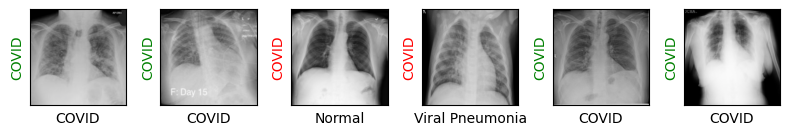

In [ ]:
show_preds(resnet18_model)

### Train function

In [ ]:
def train(model, model_name, optimizer, num_epochs):
    print('Starting training...')
    y_true = []
    y_pred = []

    # this is needed for early stopping (in case val_los doesn't decrease)
    prev_val_loss = float('inf') # Initially set to infinity

    timezone = pytz.timezone('Asia/Jerusalem')
    for epoch in trange(num_epochs): # trange - used to make our loops show a smart progress meter
        time_str = datetime.now().astimezone(timezone).strftime("%d-%m-%Y-%H:%M:%S")
        print(time_str)
        print('='*20)
        print(f'Starting epoch {epoch + 1}/{num_epochs}')
        print('='*20)

        train_loss = 0.0
        val_loss = 0.0

        model.train() # Set the model to training mode which activates dropout and batch normalization layers
        '''
        The model.train() function is typically used in PyTorch to set the model in training mode.
        When you call model.train(), it activates certain modules in the model that behave differently during training compared to evaluation/testing.
        These modules include dropout and batch normalization layers.
        During training, dropout layers randomly set a fraction of their inputs to zero,
        which helps in regularization and prevents overfitting.
        Batch normalization layers calculate batch-wise statistics and normalize the inputs, aiding in faster convergence and improved generalization.
        By default, PyTorch sets the model to training mode when you create an instance of it.
        However, it's good practice to call model.train() explicitly before the training loop to ensure that the model is indeed in the training mode.
        '''
        for train_step, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)

            #loss = outputs.loss (this line is used when there is no loss_fn defined)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if train_step % 20 == 0:
                time_str = datetime.now().astimezone(timezone).strftime("%d-%m-%Y-%H:%M:%S")
                print(time_str)
                print('Evaluating at step', train_step)

                accuracy = 0

                model.eval() # Put the model into evaluation mode which disables dropout and batch normalization layers

                for val_step, (images, labels) in enumerate(test_loader):
                    outputs = model(images)

                    loss = loss_fn(outputs, labels)

                    val_loss += loss.item()

                    # Add softmax activation function to obtain the probabilities for each class.
                    # Note that softmax is typically used during inference or evaluation to obtain class probabilities.
                    # During training, the model usually directly outputs logits, and the loss function handles the conversion to probabilities.
                    #probabilities = F.softmax(outputs, dim=1) # see https://www.pinecone.io/learn/train-sentence-transformers-softmax/
                    #_, preds = torch.max(probabilities, dim=1)

                    _, preds = torch.max(outputs, dim=1)

                    # 'labels' and 'preds' are tensors, so we cast them to numpy arrays
                    y_true.extend(labels.cpu().numpy()) #  labels.flatten().tolist()
                    y_pred.extend(preds.cpu().numpy())

                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)

                time_str = datetime.now().astimezone(timezone).strftime("%d-%m-%Y-%H:%M:%S")
                print(time_str)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                print_results(y_true, y_pred)

                show_preds(model)

                model.train() # Set the model back to training mode

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping...')
                    return

                # this is needed for early stopping (in case val_los doesn't decrease)
                if val_loss >= prev_val_loss:
                    print("Validation loss hasn't decreased from the last train_step, stopping the training.")
                    torch.save(model.state_dict(), model_name)
                    return
                prev_val_loss = val_loss # Store the val_loss of current train_step

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training...


  0%|          | 0/1 [00:00<?, ?it/s]

30-06-2023-14:03:18
Starting epoch 1/1
Evaluating at step 0
30-06-2023-14:03:20
Validation Loss: 1.4968, Accuracy: 0.2595
Precision: 0.2844
Recall: 0.2595
F1-score: 0.1395

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.25      0.95      0.40      1057
         Normal       0.30      0.03      0.06      1033
   Lung_Opacity       0.51      0.05      0.09      1095
Viral Pneumonia       0.07      0.00      0.01      1047

       accuracy                           0.26      4232
      macro avg       0.28      0.26      0.14      4232
   weighted avg       0.28      0.26      0.14      4232

Confusion Matrix:
[[1007   16   34    0]
 [ 974   32   19    8]
 [ 957   36   55   47]
 [1019   24    0    4]]


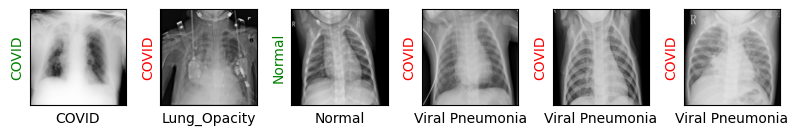

Evaluating at step 20
30-06-2023-14:14:10
Validation Loss: 1.0692, Accuracy: 0.5449
Precision: 0.5179
Recall: 0.4022
F1-score: 0.3863

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.28      0.66      0.40      2136
         Normal       0.53      0.09      0.15      2101
   Lung_Opacity       0.44      0.43      0.44      2104
Viral Pneumonia       0.81      0.43      0.56      2123

       accuracy                           0.40      8464
      macro avg       0.52      0.40      0.39      8464
   weighted avg       0.52      0.40      0.39      8464

Confusion Matrix:
[[1402   61  653   20]
 [1305  181  479  136]
 [1077   64  912   51]
 [1161   34   19  909]]


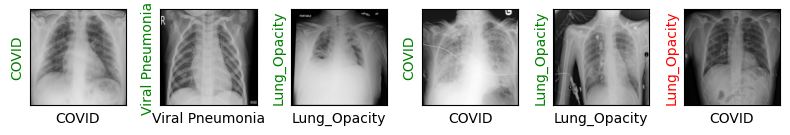

Evaluating at step 40
30-06-2023-14:19:27
Validation Loss: 0.8789, Accuracy: 0.6399
Precision: 0.5771
Recall: 0.4814
F1-score: 0.4658

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.33      0.59      0.42      3206
         Normal       0.66      0.12      0.20      3135
   Lung_Opacity       0.46      0.60      0.52      3125
Viral Pneumonia       0.86      0.61      0.71      3230

       accuracy                           0.48     12696
      macro avg       0.58      0.48      0.46     12696
   weighted avg       0.58      0.48      0.47     12696

Confusion Matrix:
[[1898   75 1211   22]
 [1526  371  997  241]
 [1114   76 1881   54]
 [1192   43   33 1962]]


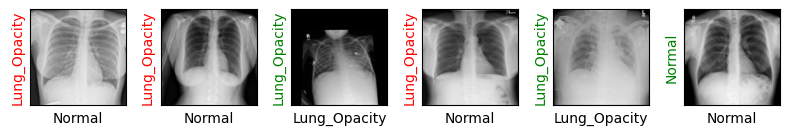

Evaluating at step 60
30-06-2023-14:22:42
Validation Loss: 0.6273, Accuracy: 0.7746
Precision: 0.6353
Recall: 0.5547
F1-score: 0.5447

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.39      0.62      0.48      4223
         Normal       0.76      0.21      0.33      4196
   Lung_Opacity       0.51      0.68      0.59      4187
Viral Pneumonia       0.87      0.70      0.78      4322

       accuracy                           0.55     16928
      macro avg       0.63      0.55      0.54     16928
   weighted avg       0.64      0.55      0.54     16928

Confusion Matrix:
[[2620  123 1453   27]
 [1770  882 1188  356]
 [1176  114 2841   56]
 [1196   43   36 3047]]


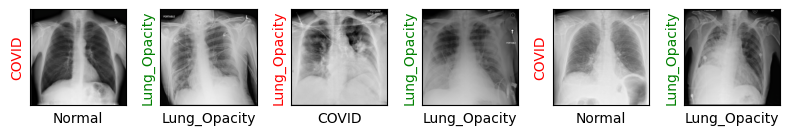

Evaluating at step 80
30-06-2023-14:25:09
Validation Loss: 0.5324, Accuracy: 0.8133
Precision: 0.6671
Recall: 0.6064
F1-score: 0.6013

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.44      0.66      0.53      5267
         Normal       0.77      0.30      0.43      5257
   Lung_Opacity       0.56      0.71      0.63      5259
Viral Pneumonia       0.89      0.76      0.82      5377

       accuracy                           0.61     21160
      macro avg       0.67      0.61      0.60     21160
   weighted avg       0.67      0.61      0.60     21160

Confusion Matrix:
[[3473  201 1563   30]
 [1979 1560 1299  419]
 [1289  192 3721   57]
 [1199   60   40 4078]]


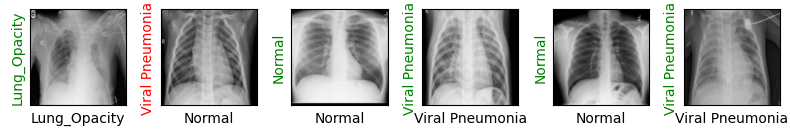

Evaluating at step 100
30-06-2023-14:27:12
Validation Loss: 0.4912, Accuracy: 0.8329
Precision: 0.6917
Recall: 0.6442
F1-score: 0.6406

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.48      0.69      0.56      6314
         Normal       0.79      0.36      0.49      6343
   Lung_Opacity       0.60      0.73      0.66      6281
Viral Pneumonia       0.89      0.80      0.84      6454

       accuracy                           0.64     25392
      macro avg       0.69      0.64      0.64     25392
   weighted avg       0.69      0.64      0.64     25392

Confusion Matrix:
[[4344  278 1657   35]
 [2141 2277 1411  514]
 [1380  257 4587   57]
 [1199   66   40 5149]]


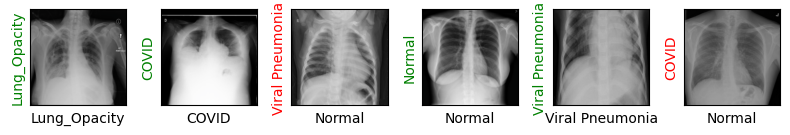

Evaluating at step 120
30-06-2023-14:29:05
Validation Loss: 0.4511, Accuracy: 0.8504
Precision: 0.7061
Recall: 0.6736
F1-score: 0.6727

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.52      0.70      0.59      7382
         Normal       0.77      0.43      0.56      7461
   Lung_Opacity       0.63      0.74      0.68      7320
Viral Pneumonia       0.91      0.82      0.86      7461

       accuracy                           0.67     29624
      macro avg       0.71      0.67      0.67     29624
   weighted avg       0.71      0.67      0.67     29624

Confusion Matrix:
[[5183  468 1693   38]
 [2205 3235 1475  546]
 [1460  403 5398   59]
 [1199   82   40 6140]]


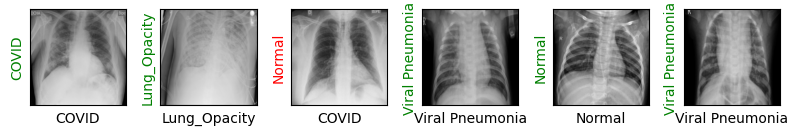

Evaluating at step 140
30-06-2023-14:30:47
Validation Loss: 0.4336, Accuracy: 0.8504
Precision: 0.7224
Recall: 0.6957
F1-score: 0.6956

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.54      0.73      0.62      8462
         Normal       0.78      0.48      0.59      8513
   Lung_Opacity       0.65      0.74      0.69      8354
Viral Pneumonia       0.92      0.84      0.88      8527

       accuracy                           0.70     33856
      macro avg       0.72      0.70      0.70     33856
   weighted avg       0.72      0.70      0.70     33856

Confusion Matrix:
[[6151  560 1712   39]
 [2377 4046 1532  558]
 [1613  506 6173   62]
 [1199  103   40 7185]]


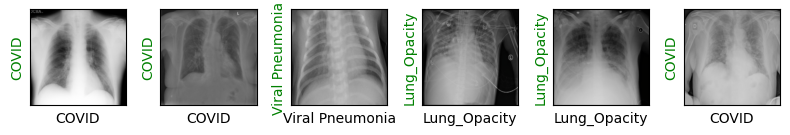

Evaluating at step 160
30-06-2023-14:32:27
Validation Loss: 0.3943, Accuracy: 0.8693
Precision: 0.7359
Recall: 0.7150
F1-score: 0.7151

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.57      0.74      0.64      9511
         Normal       0.78      0.51      0.62      9568
   Lung_Opacity       0.67      0.75      0.71      9421
Viral Pneumonia       0.92      0.86      0.89      9588

       accuracy                           0.72     38088
      macro avg       0.74      0.72      0.71     38088
   weighted avg       0.74      0.72      0.72     38088

Confusion Matrix:
[[7006  662 1794   49]
 [2452 4904 1624  588]
 [1645  624 7088   64]
 [1199  113   40 8236]]


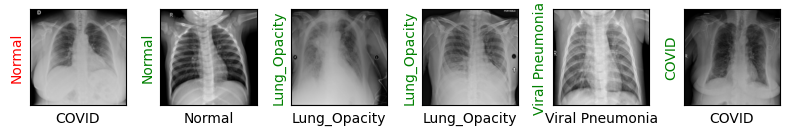

Evaluating at step 180
30-06-2023-14:34:05
Validation Loss: 0.3751, Accuracy: 0.8849
Precision: 0.7493
Recall: 0.7320
F1-score: 0.7321

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.59      0.75      0.66     10573
         Normal       0.79      0.54      0.64     10583
   Lung_Opacity       0.69      0.77      0.73     10507
Viral Pneumonia       0.93      0.87      0.90     10657

       accuracy                           0.73     42320
      macro avg       0.75      0.73      0.73     42320
   weighted avg       0.75      0.73      0.73     42320

Confusion Matrix:
[[7902  751 1866   54]
 [2506 5723 1752  602]
 [1690  688 8064   65]
 [1199  128   40 9290]]


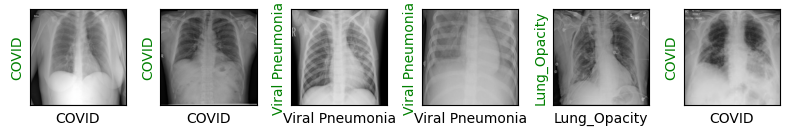

Evaluating at step 200
30-06-2023-14:35:41
Validation Loss: 0.3616, Accuracy: 0.8823
Precision: 0.7596
Recall: 0.7457
F1-score: 0.7458

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.62      0.76      0.68     11647
         Normal       0.79      0.57      0.66     11622
   Lung_Opacity       0.70      0.77      0.74     11586
Viral Pneumonia       0.93      0.88      0.91     11697

       accuracy                           0.75     46552
      macro avg       0.76      0.75      0.75     46552
   weighted avg       0.76      0.75      0.75     46552

Confusion Matrix:
[[ 8821   856  1915    55]
 [ 2581  6591  1829   621]
 [ 1738   803  8979    66]
 [ 1199   136    40 10322]]


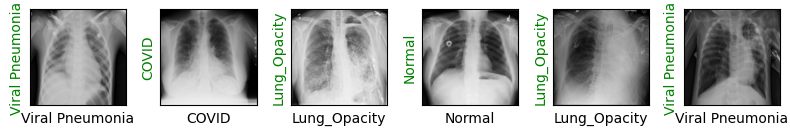

Evaluating at step 220
30-06-2023-14:37:17
Validation Loss: 0.3733, Accuracy: 0.8689
Precision: 0.7688
Recall: 0.7559
F1-score: 0.7560

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.63      0.77      0.69     12742
         Normal       0.79      0.58      0.67     12671
   Lung_Opacity       0.72      0.78      0.75     12601
Viral Pneumonia       0.94      0.89      0.91     12770

       accuracy                           0.76     50784
      macro avg       0.77      0.76      0.76     50784
   weighted avg       0.77      0.76      0.76     50784

Confusion Matrix:
[[ 9849   895  1940    58]
 [ 2795  7349  1897   630]
 [ 1832   889  9813    67]
 [ 1199   152    40 11379]]


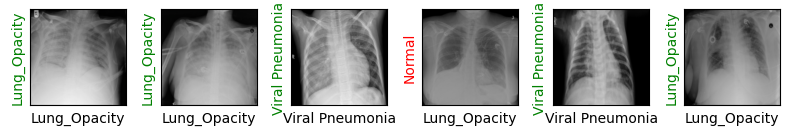

  0%|          | 0/1 [35:04<?, ?it/s]

Validation loss hasn't decreased from the last train_step, stopping the training.
CPU times: user 1h 19min 35s, sys: 1min 1s, total: 1h 20min 37s
Wall time: 35min 4s


In [ ]:
%%time
train(resnet18_model, "resnet18_model", resnet18_optimizer, num_epochs=NUM_EPOCHS)

### Final Results

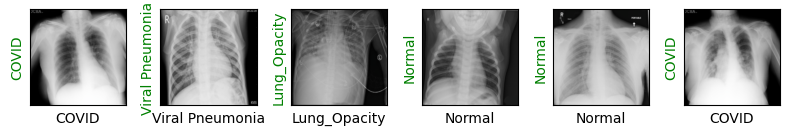

In [ ]:
show_preds(resnet18_model)

### Save or load the model

In [ ]:
# torch.save(resnet18_model, "resnet18_full_model")
# resnet18_model = torch.load("resnet18_full_model")

## ResNet-50

### Create the Model

In [ ]:
resnet50_model = resnet50(weights=ResNet50_Weights.DEFAULT)

print(resnet50_model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 343MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Set final layer and optimizer

In [ ]:
resnet50_model.fc = nn.Linear(in_features=2048, out_features=4) # (TODO: change in_features? )
resnet50_optimizer = Adam(resnet50_model.parameters(), lr=LEARNING_RATE)

### Training

Starting training...


  0%|          | 0/1 [00:00<?, ?it/s]

30-06-2023-14:38:25
Starting epoch 1/1
Evaluating at step 0
30-06-2023-14:38:27
Validation Loss: 1.3899, Accuracy: 0.2495
Precision: 0.2583
Recall: 0.2495
F1-score: 0.1845

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.26      0.73      0.38      1081
         Normal       0.27      0.06      0.09      1055
   Lung_Opacity       0.19      0.16      0.17       985
Viral Pneumonia       0.30      0.05      0.09      1111

       accuracy                           0.25      4232
      macro avg       0.26      0.25      0.18      4232
   weighted avg       0.26      0.25      0.18      4232

Confusion Matrix:
[[784  54 207  36]
 [714  60 231  50]
 [756  29 155  45]
 [744  76 234  57]]


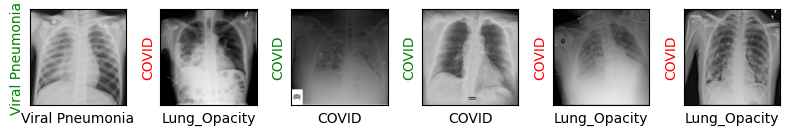

Evaluating at step 20
30-06-2023-14:41:17
Validation Loss: 1.3629, Accuracy: 0.3549
Precision: 0.3491
Recall: 0.3022
F1-score: 0.2977

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.28      0.48      0.35      2133
         Normal       0.27      0.28      0.28      2112
   Lung_Opacity       0.27      0.24      0.26      2089
Viral Pneumonia       0.57      0.21      0.31      2130

       accuracy                           0.30      8464
      macro avg       0.35      0.30      0.30      8464
   weighted avg       0.35      0.30      0.30      8464

Confusion Matrix:
[[1014  625  410   84]
 [ 851  587  511  163]
 [ 968  524  511   86]
 [ 816  417  451  446]]


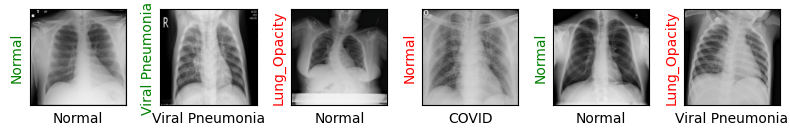

Evaluating at step 40
30-06-2023-14:44:07
Validation Loss: 1.3047, Accuracy: 0.5562
Precision: 0.4183
Recall: 0.3869
F1-score: 0.3942

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.32      0.43      0.37      3169
         Normal       0.33      0.34      0.33      3181
   Lung_Opacity       0.35      0.35      0.35      3120
Viral Pneumonia       0.67      0.43      0.53      3226

       accuracy                           0.39     12696
      macro avg       0.42      0.39      0.39     12696
   weighted avg       0.42      0.39      0.39     12696

Confusion Matrix:
[[1359  938  686  186]
 [ 947 1072  822  340]
 [1113  766 1080  161]
 [ 835  455  535 1401]]


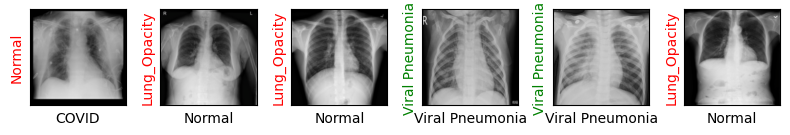

Evaluating at step 60
30-06-2023-14:46:56
Validation Loss: 1.2256, Accuracy: 0.6524
Precision: 0.4733
Recall: 0.4533
F1-score: 0.4601

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.36      0.41      0.39      4248
         Normal       0.39      0.42      0.40      4241
   Lung_Opacity       0.42      0.42      0.42      4167
Viral Pneumonia       0.73      0.56      0.63      4272

       accuracy                           0.45     16928
      macro avg       0.47      0.45      0.46     16928
   weighted avg       0.47      0.45      0.46     16928

Confusion Matrix:
[[1743 1354  930  221]
 [1003 1785  965  488]
 [1201 1019 1747  200]
 [ 841  475  558 2398]]


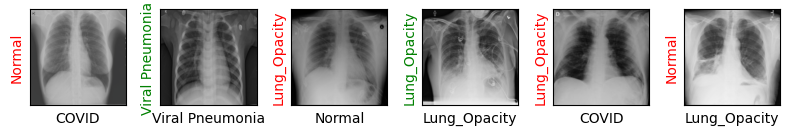

Evaluating at step 80
30-06-2023-14:49:45
Validation Loss: 1.1037, Accuracy: 0.6791
Precision: 0.5100
Recall: 0.4984
F1-score: 0.5026

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.40      0.39      0.40      5362
         Normal       0.42      0.46      0.44      5239
   Lung_Opacity       0.46      0.50      0.48      5242
Viral Pneumonia       0.75      0.64      0.69      5317

       accuracy                           0.50     21160
      macro avg       0.51      0.50      0.50     21160
   weighted avg       0.51      0.50      0.50     21160

Confusion Matrix:
[[2097 1693 1328  244]
 [1042 2408 1159  630]
 [1247 1130 2630  235]
 [ 841  475  589 3412]]


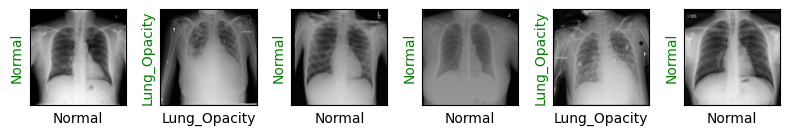

Evaluating at step 100
30-06-2023-14:52:35
Validation Loss: 1.0275, Accuracy: 0.7063
Precision: 0.5400
Recall: 0.5331
F1-score: 0.5347

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.43      0.38      0.40      6423
         Normal       0.45      0.51      0.47      6265
   Lung_Opacity       0.50      0.55      0.53      6341
Viral Pneumonia       0.78      0.70      0.73      6363

       accuracy                           0.53     25392
      macro avg       0.54      0.53      0.53     25392
   weighted avg       0.54      0.53      0.53     25392

Confusion Matrix:
[[2438 2117 1616  252]
 [1062 3170 1261  772]
 [1276 1323 3498  244]
 [ 841  490  602 4430]]


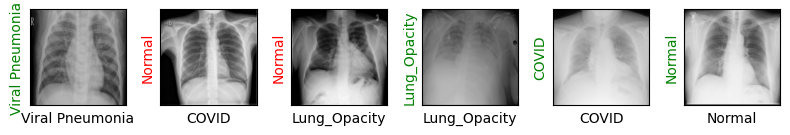

Evaluating at step 120
30-06-2023-14:55:25
Validation Loss: 0.9237, Accuracy: 0.7502
Precision: 0.5680
Recall: 0.5641
F1-score: 0.5637

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.47      0.39      0.42      7443
         Normal       0.48      0.54      0.51      7395
   Lung_Opacity       0.53      0.59      0.56      7368
Viral Pneumonia       0.79      0.74      0.76      7418

       accuracy                           0.56     29624
      macro avg       0.57      0.56      0.56     29624
   weighted avg       0.57      0.56      0.56     29624

Confusion Matrix:
[[2866 2389 1932  256]
 [1089 4011 1386  909]
 [1297 1454 4373  244]
 [ 841  490  626 5461]]


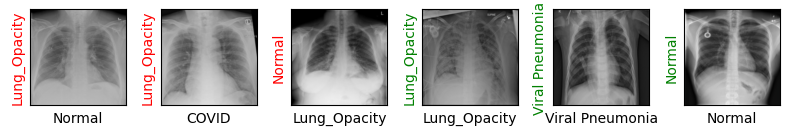

Evaluating at step 140
30-06-2023-14:58:13
Validation Loss: 0.8328, Accuracy: 0.7519
Precision: 0.5899
Recall: 0.5876
F1-score: 0.5855

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.50      0.39      0.44      8500
         Normal       0.50      0.57      0.53      8444
   Lung_Opacity       0.55      0.63      0.58      8419
Viral Pneumonia       0.81      0.77      0.79      8493

       accuracy                           0.59     33856
      macro avg       0.59      0.59      0.59     33856
   weighted avg       0.59      0.59      0.59     33856

Confusion Matrix:
[[3274 2723 2245  258]
 [1106 4822 1498 1018]
 [1318 1589 5265  247]
 [ 841  490  630 6532]]


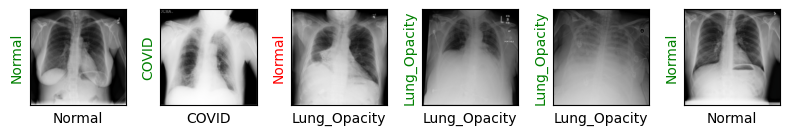

Evaluating at step 160
30-06-2023-15:01:02
Validation Loss: 0.7797, Accuracy: 0.7377
Precision: 0.6056
Recall: 0.6043
F1-score: 0.6005

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.53      0.38      0.44      9583
         Normal       0.51      0.59      0.55      9472
   Lung_Opacity       0.56      0.65      0.60      9511
Viral Pneumonia       0.82      0.79      0.81      9522

       accuracy                           0.60     38088
      macro avg       0.61      0.60      0.60     38088
   weighted avg       0.61      0.60      0.60     38088

Confusion Matrix:
[[3658 3085 2572  268]
 [1113 5613 1599 1147]
 [1334 1745 6183  249]
 [ 841  490  630 7561]]


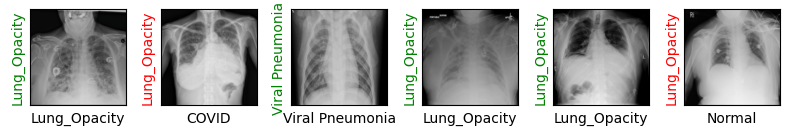

Evaluating at step 180
30-06-2023-15:03:49
Validation Loss: 0.7049, Accuracy: 0.7736
Precision: 0.6227
Recall: 0.6212
F1-score: 0.6169

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.56      0.40      0.46     10684
         Normal       0.53      0.61      0.57     10520
   Lung_Opacity       0.58      0.67      0.62     10556
Viral Pneumonia       0.83      0.81      0.82     10560

       accuracy                           0.62     42320
      macro avg       0.62      0.62      0.62     42320
   weighted avg       0.62      0.62      0.62     42320

Confusion Matrix:
[[4223 3363 2823  275]
 [1144 6428 1689 1259]
 [1365 1902 7039  250]
 [ 841  490  630 8599]]


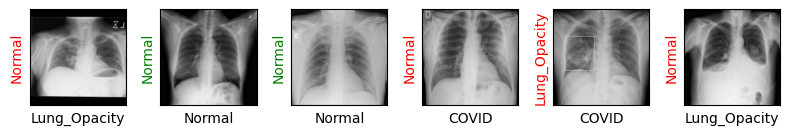

Evaluating at step 200
30-06-2023-15:06:36
Validation Loss: 0.6873, Accuracy: 0.7982
Precision: 0.6388
Recall: 0.6373
F1-score: 0.6332

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.59      0.42      0.49     11768
         Normal       0.54      0.62      0.58     11556
   Lung_Opacity       0.60      0.68      0.64     11662
Viral Pneumonia       0.83      0.83      0.83     11566

       accuracy                           0.64     46552
      macro avg       0.64      0.64      0.63     46552
   weighted avg       0.64      0.64      0.63     46552

Confusion Matrix:
[[4952 3563 2970  283]
 [1231 7168 1773 1384]
 [1428 2034 7948  252]
 [ 841  490  636 9599]]


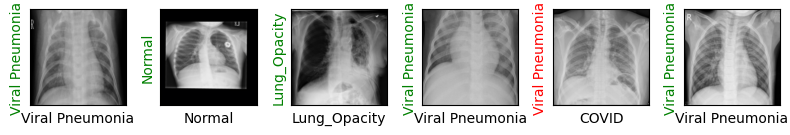

Evaluating at step 220
30-06-2023-15:09:25
Validation Loss: 0.6346, Accuracy: 0.8067
Precision: 0.6529
Recall: 0.6514
F1-score: 0.6476

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.61      0.44      0.51     12854
         Normal       0.55      0.63      0.59     12604
   Lung_Opacity       0.61      0.69      0.65     12711
Viral Pneumonia       0.84      0.84      0.84     12615

       accuracy                           0.65     50784
      macro avg       0.65      0.65      0.65     50784
   weighted avg       0.65      0.65      0.65     50784

Confusion Matrix:
[[ 5704  3744  3114   292]
 [ 1313  7908  1871  1512]
 [ 1485  2150  8821   255]
 [  841   490   636 10648]]


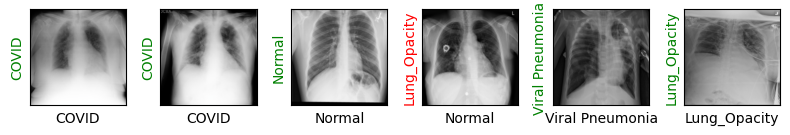

Evaluating at step 240
30-06-2023-15:12:13
Validation Loss: 0.6212, Accuracy: 0.8251
Precision: 0.6660
Recall: 0.6648
F1-score: 0.6615

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.62      0.47      0.53     13862
         Normal       0.57      0.64      0.60     13659
   Lung_Opacity       0.63      0.70      0.66     13783
Viral Pneumonia       0.85      0.86      0.85     13712

       accuracy                           0.66     55016
      macro avg       0.67      0.67      0.66     55016
   weighted avg       0.67      0.66      0.66     55016

Confusion Matrix:
[[ 6481  3932  3156   293]
 [ 1414  8763  1911  1571]
 [ 1649  2292  9587   255]
 [  841   493   636 11742]]


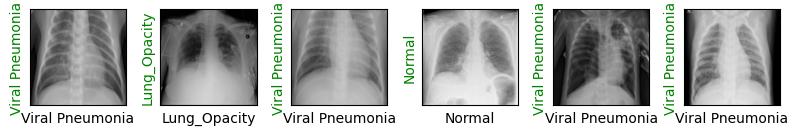

Evaluating at step 260
30-06-2023-15:15:00
Validation Loss: 0.5877, Accuracy: 0.8355
Precision: 0.6780
Recall: 0.6770
F1-score: 0.6742

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.64      0.49      0.56     14945
         Normal       0.58      0.65      0.61     14725
   Lung_Opacity       0.64      0.70      0.67     14822
Viral Pneumonia       0.85      0.87      0.86     14756

       accuracy                           0.68     59248
      macro avg       0.68      0.68      0.67     59248
   weighted avg       0.68      0.68      0.67     59248

Confusion Matrix:
[[ 7363  4041  3246   295]
 [ 1546  9555  1999  1625]
 [ 1772  2385 10410   255]
 [  841   498   636 12781]]


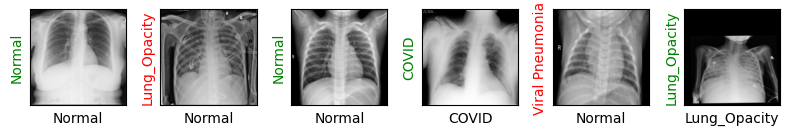

Evaluating at step 280
30-06-2023-15:17:49
Validation Loss: 0.5358, Accuracy: 0.8521
Precision: 0.6899
Recall: 0.6886
F1-score: 0.6863

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.65      0.51      0.58     16005
         Normal       0.59      0.66      0.62     15782
   Lung_Opacity       0.65      0.71      0.68     15877
Viral Pneumonia       0.86      0.87      0.87     15816

       accuracy                           0.69     63480
      macro avg       0.69      0.69      0.69     63480
   weighted avg       0.69      0.69      0.69     63480

Confusion Matrix:
[[ 8207  4203  3298   297]
 [ 1626 10436  2061  1659]
 [ 1858  2524 11240   255]
 [  844   504   636 13832]]


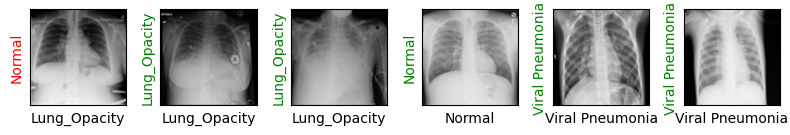

Evaluating at step 300
30-06-2023-15:20:36
Validation Loss: 0.4989, Accuracy: 0.8464
Precision: 0.6993
Recall: 0.6985
F1-score: 0.6965

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.66      0.53      0.59     17020
         Normal       0.60      0.67      0.63     16853
   Lung_Opacity       0.66      0.71      0.69     16892
Viral Pneumonia       0.87      0.88      0.87     16947

       accuracy                           0.70     67712
      macro avg       0.70      0.70      0.70     67712
   weighted avg       0.70      0.70      0.70     67712

Confusion Matrix:
[[ 9088  4309  3325   298]
 [ 1729 11229  2147  1748]
 [ 2006  2614 12017   255]
 [  844   504   636 14963]]


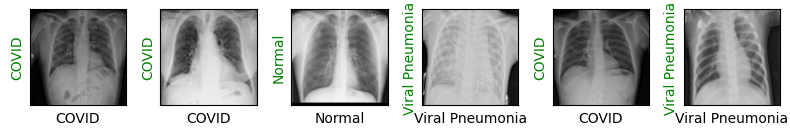

Evaluating at step 320
30-06-2023-15:23:19
Validation Loss: 0.5083, Accuracy: 0.8431
Precision: 0.7075
Recall: 0.7070
F1-score: 0.7053

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.67      0.55      0.61     18082
         Normal       0.61      0.67      0.64     17933
   Lung_Opacity       0.67      0.71      0.69     17949
Viral Pneumonia       0.87      0.89      0.88     17980

       accuracy                           0.71     71944
      macro avg       0.71      0.71      0.71     71944
   weighted avg       0.71      0.71      0.71     71944

Confusion Matrix:
[[10014  4422  3346   300]
 [ 1839 12073  2214  1807]
 [ 2170  2734 12790   255]
 [  847   504   641 15988]]


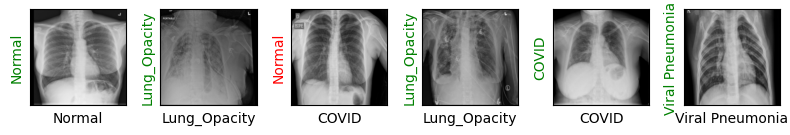

Validation loss hasn't decreased from the last train_step, stopping the training.


  0%|          | 0/1 [47:04<?, ?it/s]

CPU times: user 3h 56min 52s, sys: 2min 10s, total: 3h 59min 3s
Wall time: 47min 4s


In [ ]:
%%time
train(resnet50_model, "resnet50_model", resnet50_optimizer, num_epochs=NUM_EPOCHS)

### Final Results

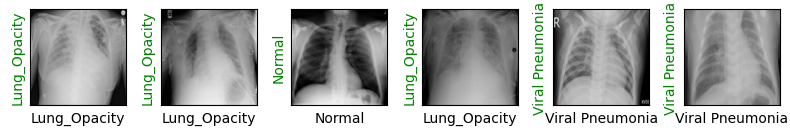

In [ ]:
show_preds(resnet50_model)

### Save or load the model

In [ ]:
# torch.save(resnet50_model, "resnet50_full_model")
# resnet50_model = torch.load("resnet50_full_model")

## VGG19

### Create the Model

In [ ]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT)

print(vgg19_model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 81.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Set final layer and optimizer

In [ ]:
vgg19_model.classifier[6] = nn.Linear(in_features=4096, out_features=4) # (TODO: change in_features? )
vgg19_optimizer = Adam(vgg19_model.parameters(), lr=LEARNING_RATE)

In [ ]:
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Training

Starting training...


  0%|          | 0/1 [00:00<?, ?it/s]

03-07-2023-15:58:04
Starting epoch 1/1
Evaluating at step 0
03-07-2023-15:58:22
Validation Loss: 1.4582, Accuracy: 0.2966
Precision: 0.3938
Recall: 0.2966
F1-score: 0.2001

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00      1059
         Normal       1.00      0.00      0.00      1029
   Lung_Opacity       0.32      0.59      0.41      1067
Viral Pneumonia       0.28      0.58      0.38      1077

       accuracy                           0.30      4232
      macro avg       0.40      0.29      0.20      4232
   weighted avg       0.39      0.30      0.20      4232

Confusion Matrix:
[[  0   0 406 653]
 [  0   1 510 518]
 [  1   0 632 434]
 [  0   0 455 622]]


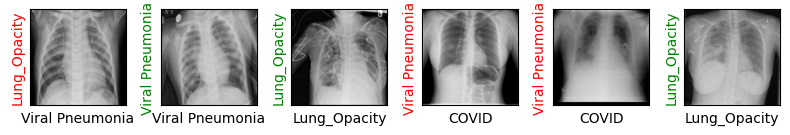

Evaluating at step 20
03-07-2023-17:07:15
Validation Loss: 0.9763, Accuracy: 0.5945
Precision: 0.5368
Recall: 0.4455
F1-score: 0.4014

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.39      0.41      0.40      2097
         Normal       0.87      0.08      0.15      2070
   Lung_Opacity       0.40      0.49      0.44      2156
Viral Pneumonia       0.49      0.78      0.60      2141

       accuracy                           0.45      8464
      macro avg       0.54      0.44      0.40      8464
   weighted avg       0.54      0.45      0.40      8464

Confusion Matrix:
[[ 855   20  548  674]
 [ 667  173  582  648]
 [ 648    5 1064  439]
 [   7    0  455 1679]]


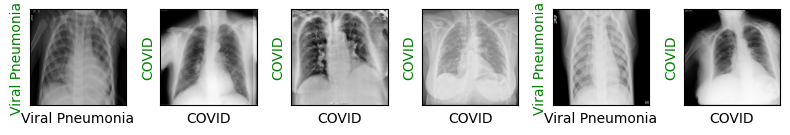

Evaluating at step 40
03-07-2023-17:55:34
Validation Loss: 0.7392, Accuracy: 0.7531
Precision: 0.5903
Recall: 0.5480
F1-score: 0.5245

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.48      0.51      0.49      3194
         Normal       0.80      0.24      0.36      3096
   Lung_Opacity       0.50      0.59      0.54      3259
Viral Pneumonia       0.58      0.85      0.69      3147

       accuracy                           0.55     12696
      macro avg       0.59      0.55      0.52     12696
   weighted avg       0.59      0.55      0.52     12696

Confusion Matrix:
[[1627  132  756  679]
 [ 898  730  683  785]
 [ 848   50 1921  440]
 [  12    0  455 2680]]


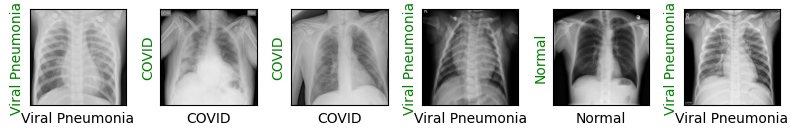

Evaluating at step 60
03-07-2023-18:38:23
Validation Loss: 0.6312, Accuracy: 0.7297
Precision: 0.5977
Recall: 0.5935
F1-score: 0.5790

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.52      0.45      0.48      4231
         Normal       0.68      0.38      0.49      4139
   Lung_Opacity       0.55      0.65      0.59      4334
Viral Pneumonia       0.65      0.89      0.75      4224

       accuracy                           0.59     16928
      macro avg       0.60      0.59      0.58     16928
   weighted avg       0.60      0.59      0.58     16928

Confusion Matrix:
[[1900  509 1119  703]
 [ 900 1592  759  888]
 [ 863  227 2800  444]
 [  12    3  455 3754]]


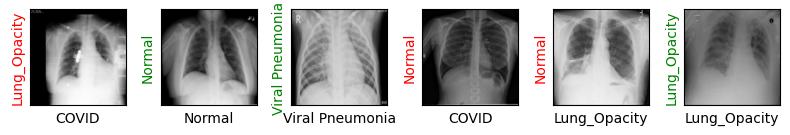

Evaluating at step 80
03-07-2023-19:18:04


  0%|          | 0/1 [3:55:05<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/execution.py", line 1327, in time
    out = eval(code, glob, local_ns)
  File "<timed eval>", line 1, in <module>
  File "<ipython-input-22-41138d26e763>", line 52, in train
    for val_step, (images, labels) in enumerate(test_loader):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 677, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipyth

In [ ]:
%%time
train(vgg19_model, "vgg19_model", vgg19_optimizer, num_epochs=NUM_EPOCHS)

### Final Results

In [ ]:
show_preds(vgg19_model)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-28-a8ec1eda66cb>", line 1, in <cell line: 1>
    show_preds(vgg19_model)
  File "<ipython-input-21-a4118189e0c4>", line 11, in show_preds
    images, labels = next(iter(test_loader))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 677, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.

### Save or load the model

In [ ]:
# torch.save(vgg19_model, "vgg19_full_model")
# vgg19_model = torch.load("vgg19_full_model")

## DenseNet-121

### Create the Model

In [ ]:
densenet121_model = densenet121(weights=DenseNet121_Weights.DEFAULT)

print(densenet121_model)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 65.9MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Set final layer

In [ ]:
num_ftrs = densenet121_model.classifier.in_features
densenet121_model.classifier = nn.Linear(num_ftrs, out_features=4)

Optionally, freeze the weights of the pre-trained layers to prevent them from being updated during training. This step can be useful if you have limited training data or if the pre-trained weights provide a good starting point

In [ ]:
# for param in densenet121_model.parameters():
#     param.requires_grad = False

### Set optimizer

In [ ]:
densenet121_optimizer = Adam(densenet121_model.parameters(), lr=LEARNING_RATE)

### Training

Starting training...


  0%|          | 0/1 [00:00<?, ?it/s]

05-07-2023-19:15:10
Starting epoch 1/1
05-07-2023-19:15:16
Evaluating at step 0
05-07-2023-19:50:15
Validation Loss: 1.6158, Accuracy: 0.2455
Precision: 0.0627
Recall: 0.2455
F1-score: 0.0999

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.00      0.00      0.00      1063
         Normal       0.25      1.00      0.41      1042
   Lung_Opacity       0.00      0.00      0.00      1096
Viral Pneumonia       0.00      0.00      0.00      1031

       accuracy                           0.25      4232
      macro avg       0.06      0.25      0.10      4232
   weighted avg       0.06      0.25      0.10      4232

Confusion Matrix:
[[   0  994    0   69]
 [   0 1039    0    3]
 [   0 1017    0   79]
 [   0 1031    0    0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

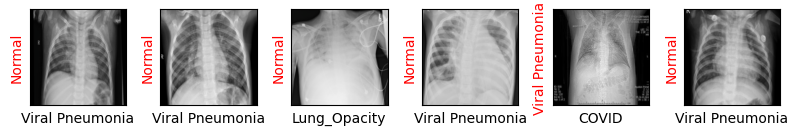

05-07-2023-19:51:59
Evaluating at step 20
05-07-2023-20:05:15
Validation Loss: 1.1956, Accuracy: 0.5059
Precision: 0.5128
Recall: 0.3757
F1-score: 0.3167

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.47      0.12      0.19      2109
         Normal       0.31      0.92      0.46      2099
   Lung_Opacity       0.69      0.09      0.16      2186
Viral Pneumonia       0.58      0.38      0.46      2070

       accuracy                           0.38      8464
      macro avg       0.51      0.38      0.32      8464
   weighted avg       0.51      0.38      0.32      8464

Confusion Matrix:
[[ 254 1589   63  203]
 [  36 1940   10  113]
 [ 250 1477  202  257]
 [   2 1266   18  784]]


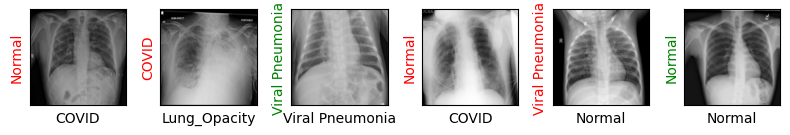

05-07-2023-20:06:58
Evaluating at step 40
05-07-2023-20:14:06
Validation Loss: 1.0006, Accuracy: 0.6418
Precision: 0.5985
Recall: 0.4644
F1-score: 0.4346

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.57      0.23      0.33      3203
         Normal       0.35      0.89      0.50      3131
   Lung_Opacity       0.79      0.18      0.29      3266
Viral Pneumonia       0.69      0.57      0.63      3096

       accuracy                           0.46     12696
      macro avg       0.60      0.47      0.44     12696
   weighted avg       0.60      0.46      0.43     12696

Confusion Matrix:
[[ 750 2099  101  253]
 [  59 2779   36  257]
 [ 495 1881  592  298]
 [  12 1284   25 1775]]


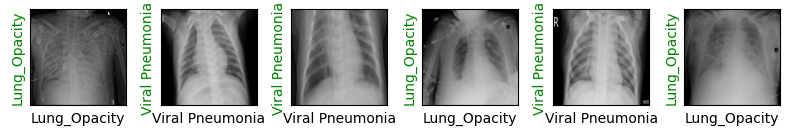

05-07-2023-20:15:47
Evaluating at step 60
05-07-2023-20:20:49
Validation Loss: 0.8504, Accuracy: 0.7706
Precision: 0.6438
Recall: 0.5409
F1-score: 0.5317

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.65      0.34      0.45      4279
         Normal       0.39      0.84      0.53      4195
   Lung_Opacity       0.80      0.31      0.45      4321
Viral Pneumonia       0.74      0.68      0.71      4133

       accuracy                           0.54     16928
      macro avg       0.64      0.54      0.53     16928
   weighted avg       0.64      0.54      0.53     16928

Confusion Matrix:
[[1472 2330  193  284]
 [ 128 3540  124  403]
 [ 637 2031 1345  308]
 [  18 1287   28 2800]]


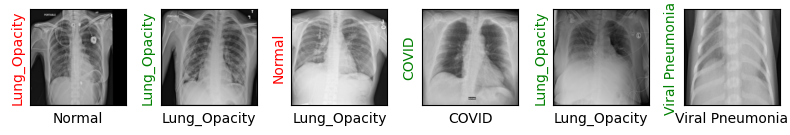

05-07-2023-20:22:29
Evaluating at step 80
05-07-2023-20:25:56
Validation Loss: 0.7280, Accuracy: 0.7935
Precision: 0.6740
Recall: 0.5914
F1-score: 0.5890

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.70      0.41      0.51      5293
         Normal       0.42      0.83      0.56      5262
   Lung_Opacity       0.80      0.40      0.53      5386
Viral Pneumonia       0.77      0.74      0.76      5219

       accuracy                           0.59     21160
      macro avg       0.67      0.59      0.59     21160
   weighted avg       0.67      0.59      0.59     21160

Confusion Matrix:
[[2157 2575  259  302]
 [ 167 4347  225  523]
 [ 739 2184 2149  314]
 [  23 1296   38 3862]]


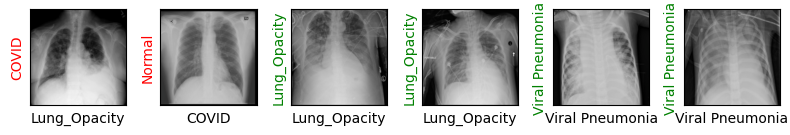

05-07-2023-20:27:34
Evaluating at step 100
05-07-2023-20:30:44
Validation Loss: 0.6571, Accuracy: 0.8188
Precision: 0.6932
Recall: 0.6293
F1-score: 0.6304

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.73      0.47      0.57      6316
         Normal       0.45      0.80      0.58      6348
   Lung_Opacity       0.80      0.47      0.59      6480
Viral Pneumonia       0.79      0.78      0.79      6248

       accuracy                           0.63     25392
      macro avg       0.69      0.63      0.63     25392
   weighted avg       0.69      0.63      0.63     25392

Confusion Matrix:
[[2939 2712  357  308]
 [ 223 5105  372  648]
 [ 823 2283 3060  314]
 [  28 1302   42 4876]]


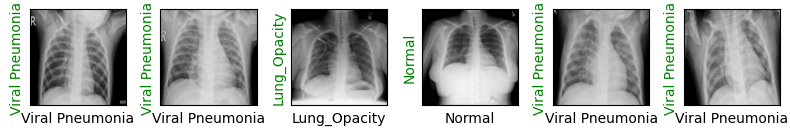

05-07-2023-20:32:20
Evaluating at step 120
05-07-2023-20:35:04
Validation Loss: 0.6137, Accuracy: 0.8247
Precision: 0.7080
Recall: 0.6572
F1-score: 0.6600

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.75      0.52      0.61      7369
         Normal       0.47      0.78      0.59      7371
   Lung_Opacity       0.80      0.52      0.63      7557
Viral Pneumonia       0.81      0.81      0.81      7327

       accuracy                           0.66     29624
      macro avg       0.71      0.66      0.66     29624
   weighted avg       0.71      0.66      0.66     29624

Confusion Matrix:
[[3825 2817  401  326]
 [ 307 5762  519  783]
 [ 940 2372 3930  315]
 [  28 1302   44 5953]]


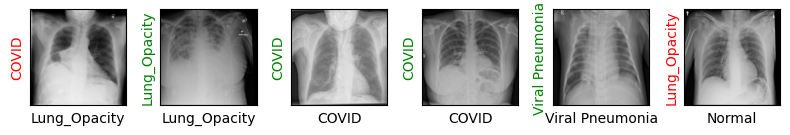

05-07-2023-20:36:37
Evaluating at step 140
05-07-2023-20:39:12
Validation Loss: 0.5517, Accuracy: 0.8341
Precision: 0.7216
Recall: 0.6793
F1-score: 0.6826

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.77      0.55      0.64      8471
         Normal       0.49      0.78      0.60      8387
   Lung_Opacity       0.80      0.56      0.66      8649
Viral Pneumonia       0.82      0.83      0.83      8349

       accuracy                           0.68     33856
      macro avg       0.72      0.68      0.68     33856
   weighted avg       0.72      0.68      0.68     33856

Confusion Matrix:
[[4687 2964  486  334]
 [ 358 6509  643  877]
 [1023 2467 4844  315]
 [  38 1304   47 6960]]


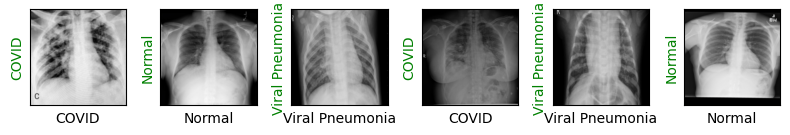

05-07-2023-20:40:51
Evaluating at step 160
05-07-2023-20:43:20
Validation Loss: 0.5217, Accuracy: 0.8575
Precision: 0.7338
Recall: 0.6991
F1-score: 0.7025

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.78      0.59      0.67      9593
         Normal       0.51      0.77      0.62      9450
   Lung_Opacity       0.81      0.59      0.68      9664
Viral Pneumonia       0.83      0.85      0.84      9381

       accuracy                           0.70     38088
      macro avg       0.73      0.70      0.70     38088
   weighted avg       0.73      0.70      0.70     38088

Confusion Matrix:
[[5679 3045  526  343]
 [ 450 7280  767  953]
 [1123 2539 5686  316]
 [  38 1310   49 7984]]


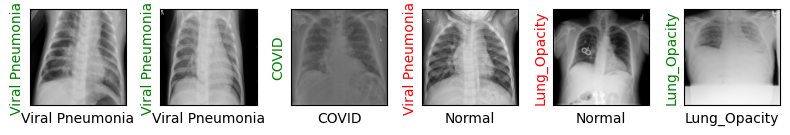

05-07-2023-20:44:57
Evaluating at step 180
05-07-2023-20:47:23
Validation Loss: 0.4765, Accuracy: 0.8490
Precision: 0.7422
Recall: 0.7141
F1-score: 0.7171

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.77      0.62      0.69     10609
         Normal       0.53      0.76      0.63     10509
   Lung_Opacity       0.82      0.61      0.70     10703
Viral Pneumonia       0.84      0.87      0.85     10499

       accuracy                           0.71     42320
      macro avg       0.74      0.71      0.72     42320
   weighted avg       0.74      0.71      0.72     42320

Confusion Matrix:
[[6620 3099  543  347]
 [ 594 8024  860 1031]
 [1297 2608 6482  316]
 [  38 1311   54 9096]]


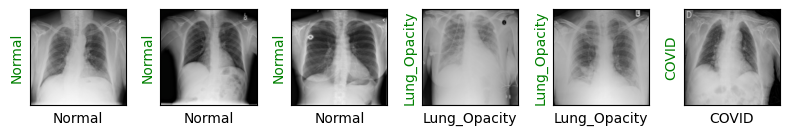

05-07-2023-20:48:57
Evaluating at step 200
05-07-2023-20:51:19
Validation Loss: 0.4371, Accuracy: 0.8620
Precision: 0.7509
Recall: 0.7276
F1-score: 0.7303

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.78      0.65      0.71     11671
         Normal       0.55      0.76      0.64     11571
   Lung_Opacity       0.82      0.63      0.71     11739
Viral Pneumonia       0.85      0.88      0.86     11571

       accuracy                           0.73     46552
      macro avg       0.75      0.73      0.73     46552
   weighted avg       0.75      0.73      0.73     46552

Confusion Matrix:
[[ 7552  3165   600   354]
 [  680  8808   999  1084]
 [ 1386  2681  7356   316]
 [   38  1323    56 10154]]


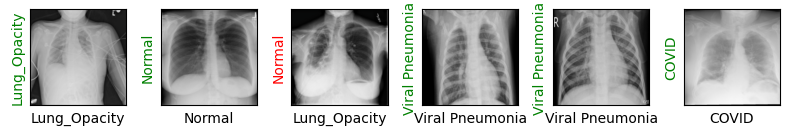

05-07-2023-20:52:54
Evaluating at step 220
05-07-2023-20:55:17
Validation Loss: 0.4404, Accuracy: 0.8554
Precision: 0.7585
Recall: 0.7382
F1-score: 0.7407

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.78      0.67      0.72     12703
         Normal       0.57      0.76      0.65     12615
   Lung_Opacity       0.83      0.64      0.72     12843
Viral Pneumonia       0.86      0.89      0.87     12623

       accuracy                           0.74     50784
      macro avg       0.76      0.74      0.74     50784
   weighted avg       0.76      0.74      0.74     50784

Confusion Matrix:
[[ 8490  3241   611   361]
 [  782  9576  1074  1183]
 [ 1519  2787  8221   316]
 [   38  1326    56 11203]]


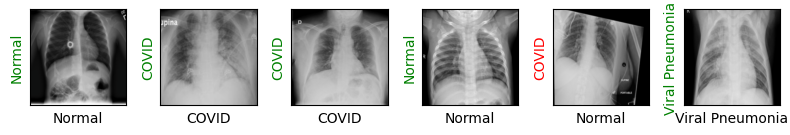

  0%|          | 0/1 [1:40:07<?, ?it/s]

Validation loss hasn't decreased from the last train_step, stopping the training.
CPU times: user 3h 57s, sys: 1min 6s, total: 3h 2min 3s
Wall time: 1h 40min 7s


In [ ]:
%%time
train(densenet121_model, "densenet121_model", densenet121_optimizer, num_epochs=NUM_EPOCHS)

### Final Results

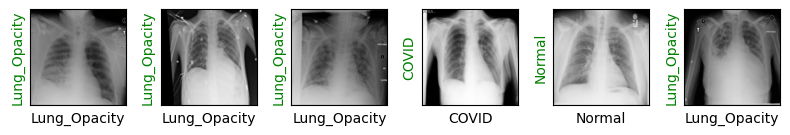

In [ ]:
show_preds(densenet121_model)

### Save or load the model

In [ ]:
# torch.save(densenet121_model, "densenet121_full_model")
# densenet121_model = torch.load("densenet121_full_model")